# Bankrupt Prediction Model

![Bankrupt Image](https://www.sawinlaw.com/wp-content/uploads/2018/09/shutterstock_605354063.jpg)

---

## Introduction

In this project, we will develop a model to predict whether a company in Poland will go bankrupt based on its financial data. The goal is to use machine learning techniques to analyze financial indicators and identify patterns that may indicate a higher risk of bankruptcy.

## Steps Involved

1. **Define the Problem and Goals**
2. **Data Loading**
3. **Data Preprocessing**
4. **Exploratory Data Analysis (EDA)**
5. **Feature Selection**
6. **Model Selection**
7. **Model Training and Evaluation**
8. **Model Tuning**
9. **Model Validation**
10. **Deployment**
11. **Monitoring and Maintenance**

---



### Importing Libraries

In [ ]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.0 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests
import io
import gzip
import pickle

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, minmax_scale
from imblearn.pipeline import make_pipeline


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### **1.Data Loading and Wrangling**
The data is in .gz file type (Compressed file)  
We will use gzip to open it

In [ ]:
#This function will help load the .gz to a json format
def wrangle(file_url):
    #Since the file is in my repo in git hbu we will first download it before loading
    response = requests.get(file_url)
    response.raise_for_status()

    # Use io.BytesIO to handle  the file in-memory
    with gzip.GzipFile(fileobj= io.BytesIO(response.content)) as f:
        df_json = json.load(f)
    return df_json

#Loading the Data
file_path = "https://raw.githubusercontent.com/JackronyK/Projects_Jackrony/main/Company%20Bankruptcy%20Classification%20Project/Data%20set/poland-bankruptcy-data-2009.json.gz"
df_poland = wrangle(file_path)


#### Exploring the Loaded DataFrame

In [ ]:
df_poland.keys()

dict_keys(['schema', 'data', 'metadata'])

##### Schemas

In [ ]:
df_schema = pd.DataFrame(df_poland['schema']['fields'])
#df_poland['schema']
df_schema

,name,type
0,company_id,integer
1,feat_1,number
2,feat_2,number
3,feat_3,number
4,feat_4,number
...,...,...
61,feat_61,number
62,feat_62,number
63,feat_63,number
64,feat_64,number


Above shows the various fields that our data have .. We have 67 fields and all of them apart from company_id and bankrupt are numbers

In [ ]:
df_poland['schema']['primaryKey']

['company_id']

Primary Key is Company_id .. we willl use it to index our data

##### Metadata

In [ ]:
df_poland['metadata']

{'title': 'Ensemble Boosted Trees with Synthetic Features Generation in Application to Bankruptcy Prediction',
 'authors': 'Zieba, M., Tomczak, S. K., & Tomczak, J. M.',
 'journal': 'Expert Systems with Applications',
 'publicationYear': 2016,
 'dataYear': 2009,
 'articleLink': 'doi:10.1016/j.eswa.2016.04.001',
 'datasetLink': 'https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data'}

##### Data

In [ ]:
df_poland['data'][0]

{'company_id': 1,
 'feat_1': 0.17419,
 'feat_2': 0.41299,
 'feat_3': 0.14371,
 'feat_4': 1.348,
 'feat_5': -28.982,
 'feat_6': 0.60383,
 'feat_7': 0.21946,
 'feat_8': 1.1225,
 'feat_9': 1.1961,
 'feat_10': 0.46359,
 'feat_11': 0.21946,
 'feat_12': 0.53139,
 'feat_13': 0.14233,
 'feat_14': 0.21946,
 'feat_15': 592.24,
 'feat_16': 0.6163,
 'feat_17': 2.4213,
 'feat_18': 0.21946,
 'feat_19': 0.12272,
 'feat_20': 37.573,
 'feat_21': 0.9969,
 'feat_22': 0.2951,
 'feat_23': 0.097402,
 'feat_24': 0.75641,
 'feat_25': 0.46359,
 'feat_26': 0.50669,
 'feat_27': 1.9737,
 'feat_28': 0.32417,
 'feat_29': 5.9473,
 'feat_30': 0.22493,
 'feat_31': 0.12272,
 'feat_32': 100.82,
 'feat_33': 3.6203,
 'feat_34': 0.71453,
 'feat_35': 0.2951,
 'feat_36': 1.8079,
 'feat_37': 123140.0,
 'feat_38': 0.46359,
 'feat_39': 0.16501,
 'feat_40': 0.21282,
 'feat_41': 0.041124,
 'feat_42': 0.16501,
 'feat_43': 95.682,
 'feat_44': 58.109,
 'feat_45': 0.94621,
 'feat_46': 0.90221,
 'feat_47': 44.941,
 'feat_48': 0.26003,

#### Modifying the Wrangle function
We will now modify the wrangle function to make it return a dataframe of the data.
We make use of pd.json_normalize to convert the json file into a df

In [ ]:
#This function will help load the .gz to a json format
def wrangle(file_url):
    #Since the file is in my repo in git hbu we will first download it before loading
    response = requests.get(file_url)
    response.raise_for_status()

    # Use io.BytesIO to handle  the file in-memory
    with gzip.GzipFile(fileobj= io.BytesIO(response.content)) as f:
        df_json = json.load(f)

        #Converting the json file into a df
        df = pd.json_normalize(df_json['data']).set_index('company_id')
    return df

#Loading the Data
file_path = "https://raw.githubusercontent.com/JackronyK/Projects_Jackrony/main/Company%20Bankruptcy%20Classification%20Project/Data%20set/poland-bankruptcy-data-2009.json.gz"
df_poland = wrangle(file_path)


In [ ]:
df_poland.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


Now that we have successfully Loaded the data it is time to Explore it and get to understand what it is all about

### **2. Exploratory Data Analysis**

In [ ]:
df_poland.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.1742,0.4130,0.1437,1.3480,-28.9820,0.6038,0.2195,1.1225,1.1961,0.4636,...,0.1640,0.3757,0.8360,0.0000,9.7145,6.2813,84.2910,4.3303,4.0341,False
2,0.1462,0.4604,0.2823,1.6294,2.5952,0.0000,0.1719,1.1721,1.6018,0.5396,...,0.0275,0.2710,0.9011,0.0000,5.9882,4.1103,102.1900,3.5716,5.9500,False
3,0.0006,0.2261,0.4884,3.1599,84.8740,0.1911,0.0046,2.9881,1.0077,0.6757,...,0.0076,0.0009,0.9924,0.0000,6.7742,3.7922,64.8460,5.6287,4.4581,False
5,0.1883,0.4150,0.3423,1.9279,-58.2740,0.0000,0.2336,1.4094,1.3393,0.5850,...,0.1765,0.3219,0.8264,0.0730,2.5912,7.0756,100.5400,3.6303,4.6375,False
6,0.1821,0.5562,0.3219,1.6045,16.3140,0.0000,0.1821,0.7981,1.8126,0.4439,...,0.5558,0.4102,0.4696,0.0294,8.4553,3.3488,107.2400,3.4036,12.4540,False


In [ ]:
df_poland.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9977 entries, 1 to 10503
Data columns (total 64 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   float64


Our data has 9977 rows  and 65 columns .

*Any Null Values in the data ?*

In [ ]:
df_poland.isna().sum().sort_values(ascending= False)

feat_37     4478
feat_21      772
feat_27      665
feat_60      562
feat_45      561
            ... 
feat_10        0
feat_7         0
feat_6         0
feat_3         0
bankrupt       0
Length: 65, dtype: int64

[[Feature description](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data)]

> - Now that feat 37 has so many missing values we will drop it
> - The other columns that has relatively small null values we will use an imputer to replace those values

In [ ]:
#This function will help load the .gz to a json format
def wrangle(file_url):
    #Since the file is in my repo in git hbu we will first download it before loading
    response = requests.get(file_url)
    response.raise_for_status()

    # Use io.BytesIO to handle  the file in-memory
    with gzip.GzipFile(fileobj= io.BytesIO(response.content)) as f:
        df_json = json.load(f)

        #Converting the json file into a df
        df = pd.json_normalize(df_json['data']).set_index('company_id')
        df.drop(columns= 'feat_37', inplace= True)
    return df

#Loading the Data
file_path = "https://raw.githubusercontent.com/JackronyK/Projects_Jackrony/main/Company%20Bankruptcy%20Classification%20Project/Data%20set/poland-bankruptcy-data-2009.json.gz"
df_poland = wrangle(file_path)


In [ ]:
df_poland.isna().sum().sort_values(ascending= False)

feat_21     772
feat_27     665
feat_60     562
feat_45     561
feat_24     213
           ... 
feat_51       0
feat_57       0
feat_55       0
feat_59       0
bankrupt      0
Length: 64, dtype: int64

#### Visualizations

> - #### Bankrupt - Classes Balance

In [ ]:
df_poland['bankrupt'].value_counts()

bankrupt
False    9510
True      467
Name: count, dtype: int64

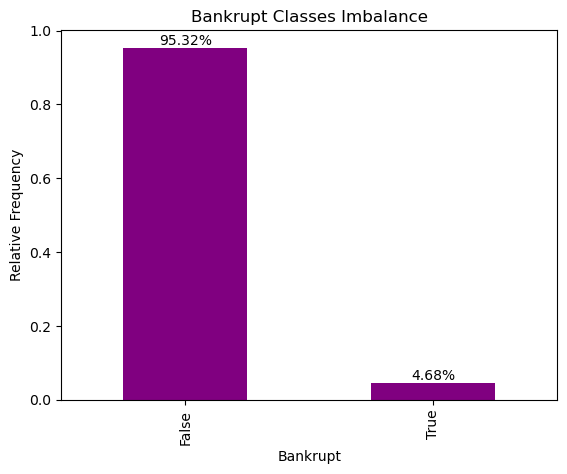

In [ ]:
#Visualizing the classes
df_poland['bankrupt'].value_counts(normalize=True).plot(
    kind = 'bar',
    xlabel= 'Bankrupt',
    ylabel= 'Relative Frequency',
    title= 'Bankrupt Classes Imbalance',
    color = 'purple'
)
#Adding data labels
ax = plt.gca()
for bar in ax.patches:
    ax.annotate(
        f"{bar.get_height():.2%}",
        (bar.get_x() + bar.get_width()/2, bar.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0,5),
        textcoords = 'offset points'
    )

plt.show()

> -- There seem to be relatively huge imbalance in our 2 classes . This would be solved using a resampler during training our model to avoid disadvantage that comes with imbalanced classes

> - #### Descriptive stats for all variables apart from bankrupt

In [ ]:
summary_stats = df_poland.drop('bankrupt', axis=1).describe().T
summary_stats['Range'] = (summary_stats['max'] - summary_stats['min']).astype(float)
pd.options.display.float_format = '{:.4f}'.format

summary_stats.sort_values(by= 'Range', ascending= False).loc['feat_4']

count    9960.0000
mean       10.0673
std       537.1287
min         0.0021
25%         1.0362
50%         1.6006
75%         2.9505
max     53433.0000
Range   53432.9979
Name: feat_4, dtype: float64

Some Feature seems to be having huge ranges. Ofcourse we will not explore all the feature but we will sample a few and look at  their distribution and also relationship with the target

> - #### feat_2 total liabilities / total assets

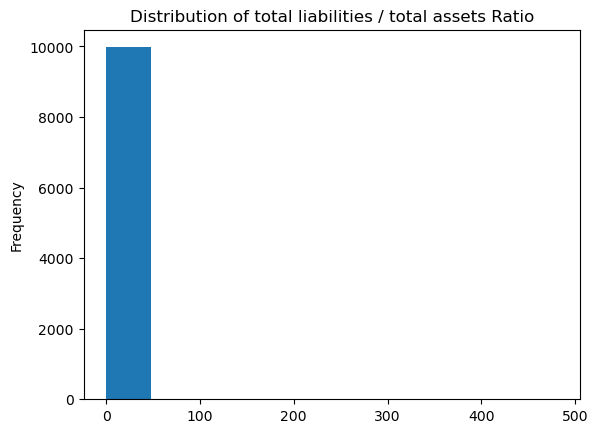

In [ ]:
df_poland['feat_2'].plot(
    kind= 'hist',
    title= 'Distribution of total liabilities / total assets Ratio'
)
plt.show()

The histogram indicate we possibly have an outliers

In [ ]:
summary_stats.sort_values(by= 'Range', ascending= False).loc['feat_2']
df_poland.sort_values(by='feat_2', ascending = False).head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
4350,7.3688,480.7300,-479.7300,0.0021,-182370.0000,-508.1200,7.3688,-0.9979,0.1635,-479.7300,...,-4.7936,-0.0154,0.1386,0.0000,NaN,0.1790,1073500.0000,0.0003,NaN,False
10322,20.4810,446.8800,-445.8800,0.0022,-3673.7000,-486.7200,20.4810,-0.9977,0.4540,-445.8600,...,0.0675,-0.0459,0.6808,0.0000,NaN,0.5122,359250.0000,0.0010,NaN,True
1498,-2.1050,24.9050,-23.9050,0.0402,-414.4600,-23.7940,-2.1050,-0.9598,19.1590,-23.9050,...,-0.0876,0.0881,1.1087,0.0000,224.1300,21.1600,474.4600,0.7693,NaN,False
1500,-17.6920,16.6690,-15.6690,0.0600,-30.2330,-7.1096,-17.6920,-0.9399,169.5000,-15.6670,...,-0.1007,1.1293,1.1044,0.0000,NaN,1060.6000,35.8940,10.1690,NaN,False
3260,-0.0300,15.9280,0.8323,5.9616,625.8900,-17.0610,-0.0300,-0.9372,1.1011,-14.9280,...,0.5687,0.0020,0.4313,-1.0557,NaN,24.2110,55.6040,6.5643,NaN,False


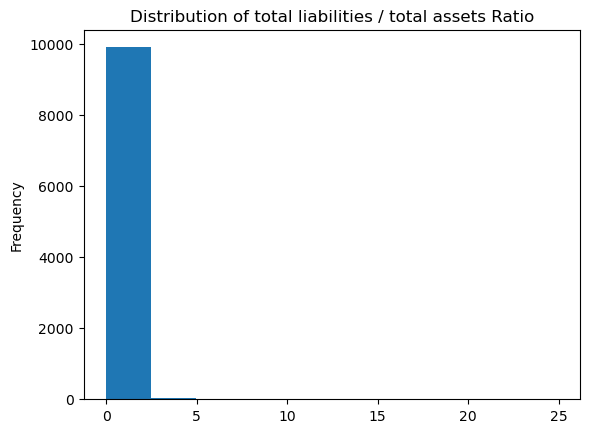

In [ ]:
df_poland[df_poland['feat_2'] <100] ['feat_2'].plot(
    kind= 'hist',
    title= 'Distribution of total liabilities / total assets Ratio'
)
plt.show()

<Axes: >

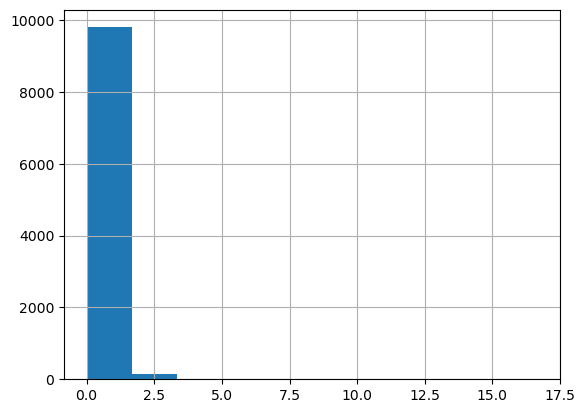

In [ ]:
df_poland[df_poland['feat_2'] < 20] ['feat_2'].hist()

It is clear the total liabilities / total assets is skwed to the right. This make sence since we expect the total liabilities/ total assets to be around single digit

> - *how is this ration distributed among the 2 classes?*

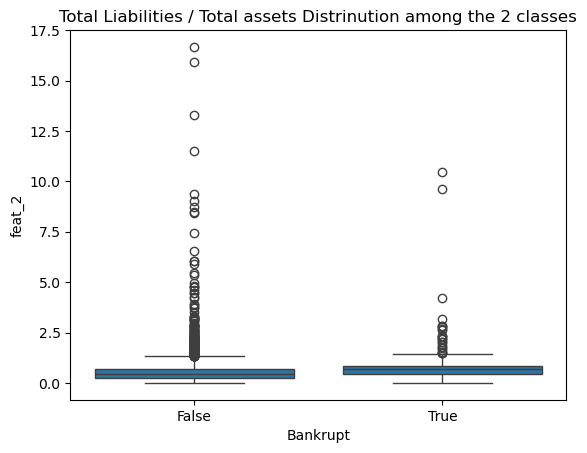

In [ ]:
#We plot boxplot for  the ration vs the target col
sns.boxplot(
    x = 'bankrupt',
    y = 'feat_2',
    data = df_poland[df_poland['feat_2'] < 20],
)
plt.xlabel('Bankrupt')
plt.title('Total Liabilities / Total assets Distrinution among the 2 classes')


plt.show()

> - #### feat 4 current assets / short-term liabilities

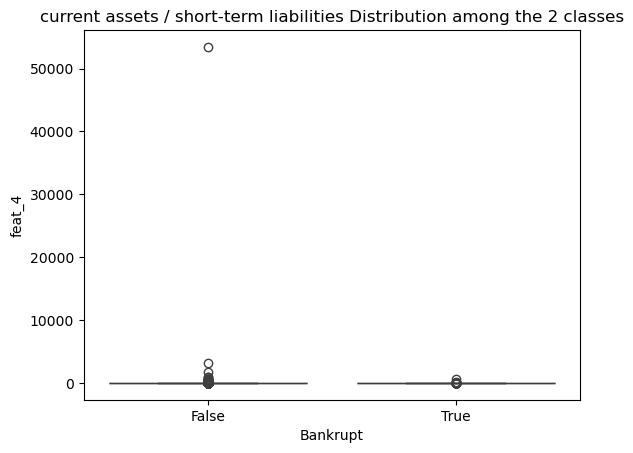

In [ ]:
sns.boxplot(
    x = 'bankrupt',
    y = 'feat_4',
    data = df_poland
)
plt.xlabel('Bankrupt')
plt.title('current assets / short-term liabilities Distribution among the 2 classes')
plt.show()

The Boxplot above shows possibility of Outliers

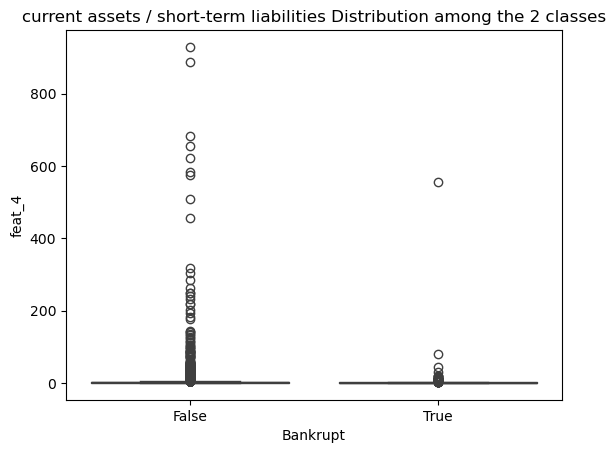

In [ ]:
sns.boxplot(
    x = 'bankrupt',
    y = 'feat_4',
    data = df_poland[df_poland['feat_4'] < 1000]
)
plt.xlabel('Bankrupt')
plt.title('current assets / short-term liabilities Distribution among the 2 classes')
plt.show()

The boxplot shows that for those the company we anticipate to be declared bankrup have a lower currebt assets / short term liabilities

> - #### feat 10 equity / total assets

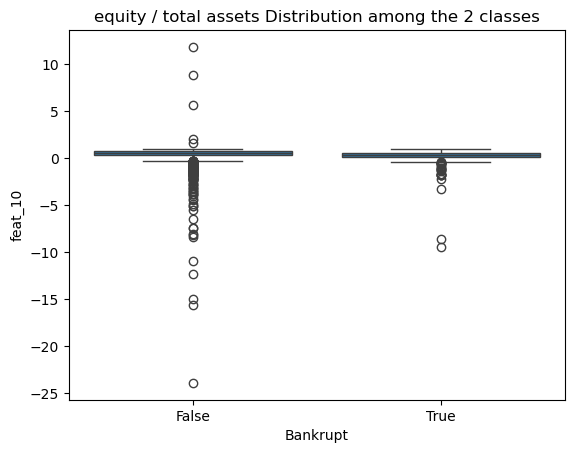

In [ ]:
sns.boxplot(
    x = 'bankrupt',
    y = 'feat_10',
    data = df_poland[df_poland['feat_10'] > -100]
)
plt.xlabel('Bankrupt')
plt.title('equity / total assets Distribution among the 2 classes')
plt.show()

From the chat above we see for the Companies we anticipate bankrupty the equity/total assets is lower compared to those that will not wide up

We could explore more feature but not match that can be gleaned that would change our data. Lastly before Preparing the data for modelling let's do correlation matrix

##### Correlation Matrix

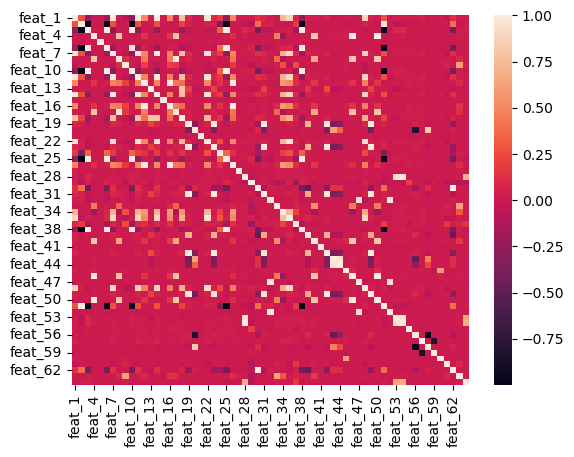

In [ ]:
#Correlation matrix
corr_mat = df_poland.drop('bankrupt', axis = 1).corr()

#Plottting the correlation matrix
sns.heatmap(corr_mat)
plt.show()

### **3. Modelling**

#### **Feature Selection**

Our target will be bankrupt and the rest will be our feature

In [ ]:
target = 'bankrupt'
y = df_poland[target]
X = df_poland.drop(target, axis = 1)

#### **Splitting into train and test set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

#### **Fitting Classifiers**
I will try 3 Classifiers namely:
- Random Forest Classifier
- Gradient Bosting Classifer
- Xg Boost Classifier

Each will be fitted, Tuned and evaluated. Later I will decide the best classifier by looking at the scores and fitting time

##### a. Random Forest Classifier

##### Pipeline, Tuning and Fitting
This pipeline will have:
- Imputer to replace the null values
- RandomOverSampler
- Standardizer
- Classifier

In [42]:
#Pipeline
rf_model = make_pipeline(
    SimpleImputer(),
    RandomOverSampler(random_state= 42),
    StandardScaler(),
    RandomForestClassifier(random_state= 42)
)

#Params Grid
params = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators' : range(100, 600, 100),
    'randomforestclassifier__max_depth' : range(10,50,10)
}

#Using a gridsearch to tune the model
model = GridSearchCV(
    estimator= rf_model,
    param_grid= params,
    n_jobs= -1,
    cv= 5
)

#Fitting
rf = model.fit(X_train, y_train)

### **Evaluations**

In [43]:
#Score
cv_score_table = pd.DataFrame(rf.cv_results_)
cv_score_table.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.647996,0.128198,0.045653,0.001022,10,100,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.934252,0.921053,0.933584,0.941103,0.935464,0.933091,0.006578,35
1,6.548370,0.111260,0.045046,0.001022,10,100,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.923607,0.922932,0.930451,0.932957,0.932957,0.928581,0.004437,40
2,13.113687,0.249255,0.080093,0.001670,10,200,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.936756,0.926065,0.937343,0.939850,0.936717,0.935346,0.004781,34
3,13.499924,0.226874,0.082682,0.000724,10,200,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.924233,0.921679,0.937970,0.932331,0.938596,0.930962,0.006939,36
4,19.752997,0.230246,0.116747,0.001340,10,300,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.939261,0.926065,0.937970,0.941729,0.935464,0.936098,0.005409,32


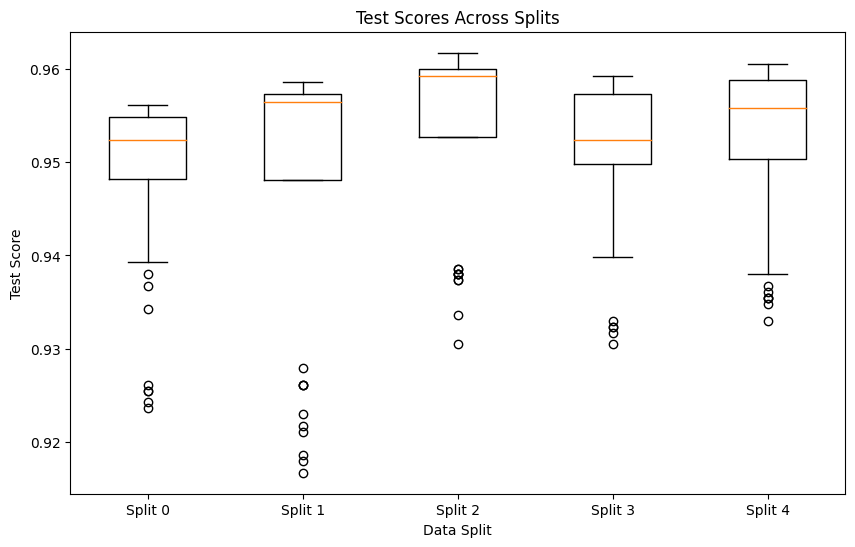

In [44]:
# @title Test Scores Across Splits

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot([cv_score_table['split0_test_score'], cv_score_table['split1_test_score'], cv_score_table['split2_test_score'], cv_score_table['split3_test_score'], cv_score_table['split4_test_score']], labels=['Split 0', 'Split 1', 'Split 2', 'Split 3', 'Split 4'])
plt.xlabel('Data Split')
plt.ylabel('Test Score')
_ = plt.title('Test Scores Across Splits')

In [45]:
#Printing best parameters and best scores
print(f'Best Parameters: {rf.best_params_}')
print(f'Best Score: {rf.best_score_}')


Best Parameters: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 100, 'simpleimputer__strategy': 'mean'}
Best Score: 0.9586521092964094


##### Testing the Model Performance on the Test Data

In [46]:
# Evaluate the model on the test set
test_score = rf.score(X_test, y_test)
print(f'Test set Score: {test_score:.2%}')


Test set Score: 96.14%


##### Classification Report

In [47]:
class_report = classification_report(y_test, rf.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1913
        True       0.61      0.20      0.31        83

    accuracy                           0.96      1996
   macro avg       0.79      0.60      0.64      1996
weighted avg       0.95      0.96      0.95      1996



##### b. Gradients Bosting Classifier

---



In [ ]:
#Pipeline
gb_model = make_pipeline(
    SimpleImputer(),
    RandomOverSampler(random_state= 42),
    StandardScaler(),
    GradientBoostingClassifier(random_state = 42)
)

# Define parameter grid for GridSearchCV
params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'gradientboostingclassifier__n_estimators': range(100, 400, 100),
    'gradientboostingclassifier__max_depth': [3, 6, 9],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingclassifier__min_samples_split': [2, 5, 10],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0]
}

#Using a gridsearch to tune the model
model = GridSearchCV(
    estimator= gb_model,
    param_grid= params,
    n_jobs= -1,
    cv= 5
)

#Fitting
gb = model.fit(X_train, y_train)

##### c. XGBoosterClassifier

In [38]:
#Pipeline
xg_model = make_pipeline(
    SimpleImputer(),
    RandomOverSampler(random_state= 42),
    StandardScaler(),
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
)

# Define parameter grid for GridSearchCV
params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 6, 9],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__subsample': [0.8, 0.9, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 0.9, 1.0]
}


#Using a gridsearch to tune the model
model = GridSearchCV(
    estimator= xg_model,
    param_grid= params,
    n_jobs= -1,
    cv= 5
)

#Fitting
xgb = model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=Non...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'simpleimputer__strategy': ['mean', 'median'],
                         'xgbclassifier__colsample_bytree': [0.8, 0.9, 1.0],
                         'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 6, 9],
                         'xgbclassifier__n_estimators': [100, 200, 300],
                         'xgbclassifier__subsample': [0.8, 0.9, 1.0]})

In [41]:
xgb.best_score_
xgb.best_params_

{'simpleimputer__strategy': 'mean',
 'xgbclassifier__colsample_bytree': 1.0,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__n_estimators': 200,
 'xgbclassifier__subsample': 0.8}